In [3]:
import torch 
from torch.utils.data import DataLoader
import transformers
from transformers import BertForSequenceClassification
from datasets import load_dataset
from transformers import AutoTokenizer

In [4]:
model_ckpt = "../artifacts/sentiment_classifier/"
model = BertForSequenceClassification.from_pretrained(model_ckpt)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [5]:
dataset = "../data/tokenized_data/test.json"
test_data = load_dataset('json' , data_files=dataset)
test_data = test_data.rename_column("label" , "labels")
test_data = test_data.remove_columns(['text'])
test_data.set_format("torch")
test_dataload = DataLoader(test_data['train'] , batch_size=64)

Using custom data configuration default-bc6d00b2491351b4
Reusing dataset json (/root/.cache/huggingface/datasets/json/default-bc6d00b2491351b4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
import evaluate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
metric = evaluate.load("accuracy")
for batch in test_dataload:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
  
    logits = outputs.logits 
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
acc = metric.compute()
print(acc)

{'accuracy': 0.5411764705882353}


In [15]:
from transformers import TextClassificationPipeline
text = "it really very good"
text_tokenized = tokenizer(text , return_tensors='pt')
inputs = {k: v.to(device) for k, v in text_tokenized.items()}
with torch.no_grad():
        outputs = model(**inputs)
        pred_label = torch.argmax(outputs.logits, axis=-1)
!pip install xformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
lll = TextClassificationPipeline(model=model.to(torch.device("cpu")), tokenizer=tokenizer, return_all_scores=True)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [64]:
outs = lll("this movie is so bad and realy i dispite it, but it contain a serve brurl scence")[0]

In [65]:
import pandas as pd

In [66]:
df = pd.DataFrame(outs)
df

,label,score
0,very_negative,0.638391
1,negative,0.289072
2,nutral,0.059564
3,positive,0.006492
4,very_positive,0.006479


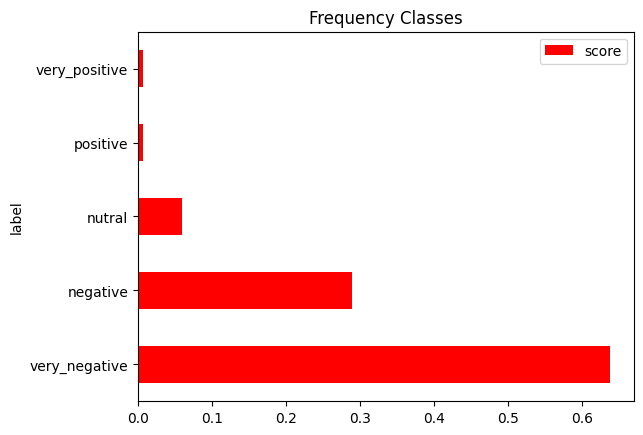

In [73]:
import matplotlib.pyplot as plt
df.plot.barh(x='label',y='score' ,color="red")
plt.title("Frequency Classes")
plt.savefig('scores.jpeg')
plt.show()